Exploration of the MSSubClass variable. The description of the variable is, "Identifies the type of dwelling involved in the sale". Possible values are:

* `20     1-STORY 1946 & NEWER ALL STYLES`
* `30     1-STORY 1945 & OLDER`
* `40     1-STORY W/FINISHED ATTIC ALL AGES`
* `40     1-1/2 STORY - UNFINISHED ALL AGES`
* `50     1-1/2 STORY FINISHED ALL AGES`
* `60     2-STORY 1946 & NEWER`
* `70     2-STORY 1945 & OLDER`
* `75     2-1/2 STORY ALL AGES`
* `80     SPLIT OR MULTI-LEVEL`
* `85     SPLIT FOYER`
* `90     DUPLEX - ALL STYLES AND AGES`
* `120    1-STORY PUD (Planned Unit Development) - 1946 & NEWER`
* `150    1-1/2 STORY PUD - ALL AGES`
* `160    2-STORY PUD - 1946 & NEWER`
* `180    PUD - MULTILEVEL - INCL SPLIT LEV/FOYER`
* `190    2 FAMILY CONVERSION - ALL STYLES AND AGES`

In [18]:
%matplotlib inline

import pandas as pd
import seaborn as sns
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from house_prices.helpers.column_categories import continuous_columns, categorical_unordered_columns, categorical_ordered_columns
from house_prices.helpers.utils import association_matrix

In [2]:
train = pd.read_csv('../data/train.csv', index_col=0).loc[:, ['MSSubClass', 'SalePrice']]

In [3]:
print(train.shape)
print(train['MSSubClass'].isnull().sum())

(1460, 2)
0


We have 1460 rows in the dataset and MSSubClass has no null values. Let's look at the distribution of values.

In [4]:
train['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

67% of all houses come from one of three MSSubClass values; 36.7% are 1-STORY 1946 & NEWER ALL STYLES, 20.5% are 2-STORY 1946 & NEWER, and 9.9% are 1-1/2 STORY FINISHED ALL AGES. These seem to be the standard types when considering houses that exist in a suburban setting.

Let's turn to the variable's relationship with SalePrice.

In [5]:
median_price_by_mssubclass = train.groupby('MSSubClass')['SalePrice'].median().sort_values()
print(median_price_by_mssubclass)

MSSubClass
180     88500
30      99900
45     107500
190    128250
50     132000
90     135980
85     140750
40     142500
160    146000
70     156000
20     159250
75     163500
80     166500
120    192000
60     215200
Name: SalePrice, dtype: int64


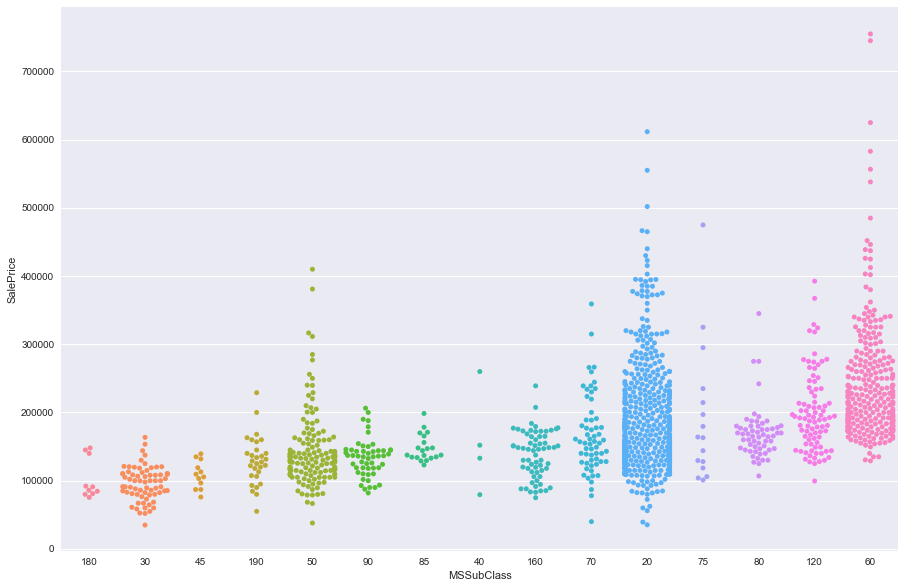

In [6]:
sns.set(rc={'figure.figsize':(15,10)})
sns.swarmplot(x='MSSubClass', y='SalePrice', order=median_price_by_mssubclass.index, data=train);

Let's check out the clustering by number of floors, year of building, pud vs. non-pud, split vs. non-split, and whatever else seems interesting.

c:\users\daniel\anaconda5.0.1-python3.6\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


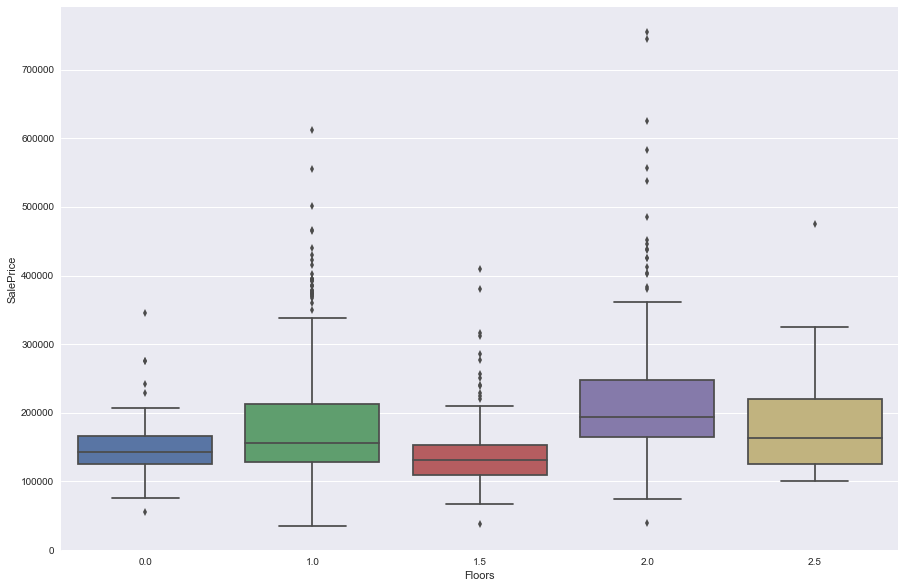

In [39]:
floor_mapping = {20: 1, 30: 1, 40: 1, 45: 1.5, 50: 1.5, 60: 2, 70: 2, 75: 2.5, 80: 0, 85: 0, 90: 0, 120: 1, 150: 1.5,
                 160: 2, 180: 0, 190: 0}
train['Floors'] = train.MSSubClass.map(floor_mapping)

sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x='Floors', y='SalePrice', data=train);

In [40]:
train.groupby('Floors')['SalePrice'].median()

Floors
0.0    142976.5
1.0    156250.0
1.5    130750.0
2.0    194000.0
2.5    163500.0
Name: SalePrice, dtype: float64

We can see 2 level homes have the highest prices. 1.5 level homes have lower prices than 1 level homes. 2.5 level homes have lower prices than 2 level homes. There are a fair amount of home categories where the number of floors is not immediately evident, and their prices are somewhere between those with 1 and 1.5 levels.

c:\users\daniel\anaconda5.0.1-python3.6\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


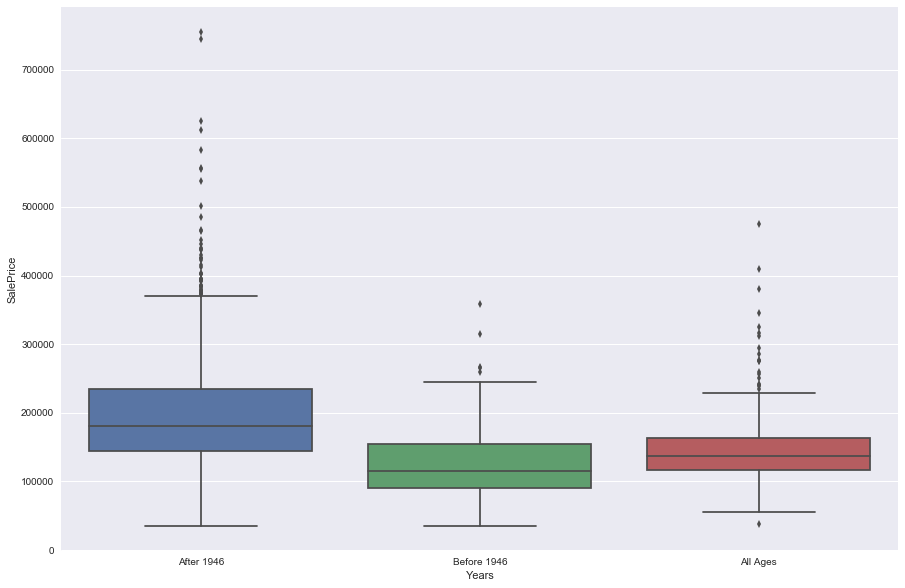

In [9]:
year_mapping = {20: 0, 30: 1, 40: 2, 45: 2, 50: 2, 60: 0, 70: 1, 75: 2, 80: 2, 85: 2, 90: 2, 120: 0, 150: 2, 160: 0, 180: 2, 
                190: 2}
train['Years'] = train.MSSubClass.map(year_mapping)

sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x='Years', y='SalePrice', data=train).set_xticklabels(['After 1946', 'Before 1946', 'All Ages']);

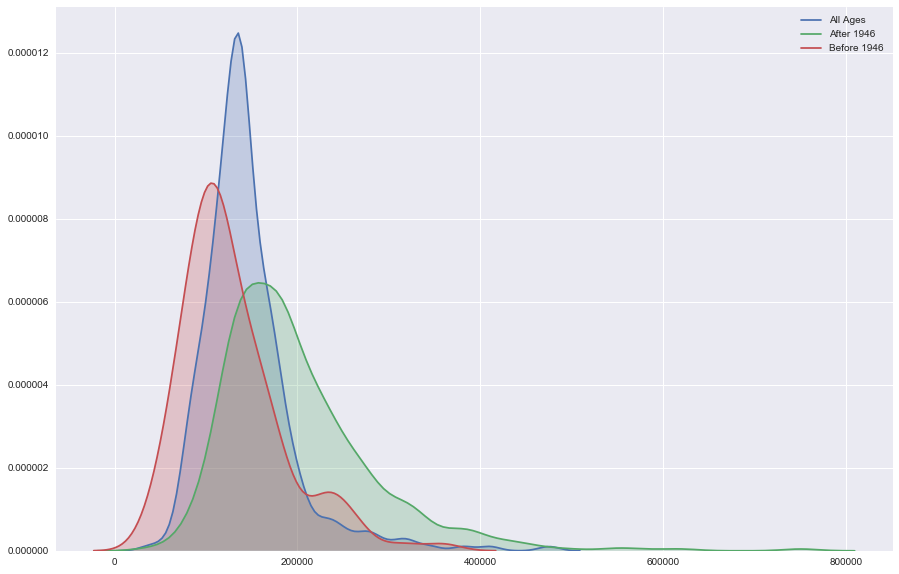

In [10]:
sns.kdeplot(train.loc[train.Years == 2, 'SalePrice'], shade=True, label='All Ages')
sns.kdeplot(train.loc[train.Years == 0, 'SalePrice'], shade=True, label='After 1946')
sns.kdeplot(train.loc[train.Years == 1, 'SalePrice'], shade=True, label='Before 1946')

Newer houses have higher prices than older houses. All ages houses have prices in between.

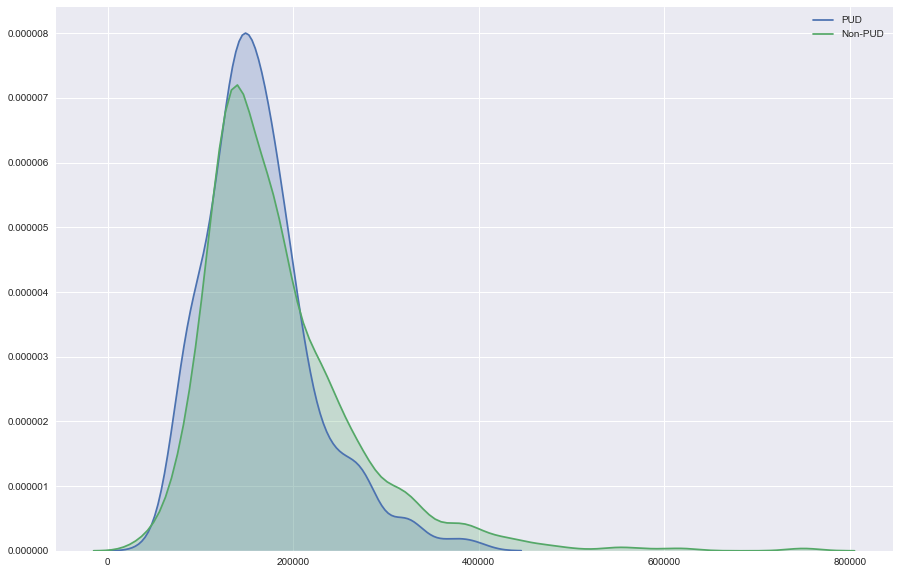

In [11]:
pud_mapping = {20: 0, 30: 0, 40: 0, 45: 0, 50: 0, 60: 0, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 120: 1, 150: 1, 160: 1, 180: 1, 
                190: 1}
train['PUD'] = train.MSSubClass.map(pud_mapping)

sns.set(rc={'figure.figsize':(15,10)})
sns.kdeplot(train.loc[train.PUD == 1, 'SalePrice'], shade=True, label='PUD')
sns.kdeplot(train.loc[train.PUD == 0, 'SalePrice'], shade=True, label='Non-PUD')

Doesn't look like much of a difference between PUD and non-PUD houses

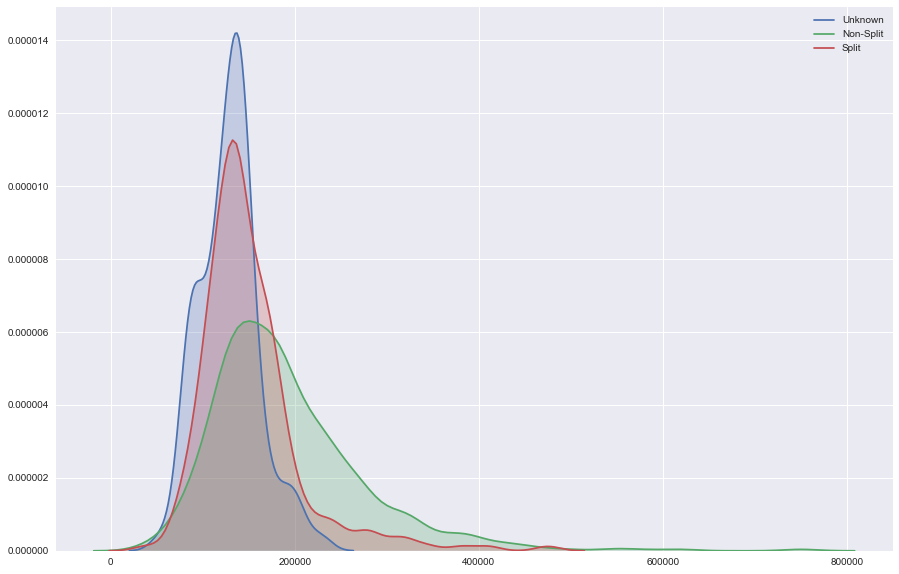

In [12]:
split_mapping = {20: 0, 30: 0, 40: 0, 45: 1, 50: 1, 60: 0, 70: 0, 75: 1, 80: 1, 85: 1, 90: 2, 120: 0, 150: 1, 160: 0, 180: 2, 
                190: 2}
train['Split'] = train.MSSubClass.map(split_mapping)

sns.set(rc={'figure.figsize':(15,10)})
sns.kdeplot(train.loc[train.Split == 2, 'SalePrice'], shade=True, label='Unknown')
sns.kdeplot(train.loc[train.Split == 0, 'SalePrice'], shade=True, label='Non-Split')
sns.kdeplot(train.loc[train.Split == 1, 'SalePrice'], shade=True, label='Split')

In [13]:
train.groupby('Split')['SalePrice'].median()

Split
0    176000
1    139000
2    132000
Name: SalePrice, dtype: int64

Non-split level homes are more expensive.

MSSubClass is an unordered categorical variable. For testing association, we'll use a corrected Cramer's V test to get association strength with other unordered categorical variables.

In [16]:
association_matrix(train, 'MSSubClass', categorical_unordered_columns)

KeyError: 'MSZoning'

What kind of models can we make with just this variable? For starters what happens if we simply predict the median value for each category?

In [31]:
test = pd.read_csv('../data/test.csv', index_col=0)

In [32]:
test['MSSubClass'].value_counts()

20     543
60     276
50     143
120     95
30      70
70      68
160     65
80      60
90      57
190     31
85      28
180      7
75       7
45       6
40       2
150      1
Name: MSSubClass, dtype: int64

We run into a problem here where the test data has an instance of a category that the train data doesn't have, 1-1/2 STORY PUD - ALL AGES. We have no median value to use. Since we have seen the age of the home and the levels in the home are useful and that the PUD status is not, we'll use the median value for 1.5 story all age homes.

In [16]:
median_price_by_mssubclass[150] = train.loc[(train.Floors == 1.5) & (train.Years == 2), 'SalePrice'].median()

In [17]:
predictions = test['MSSubClass'].map(median_price_by_mssubclass)
submission = pd.DataFrame(columns=['Id', 'SalePrice'])
submission['Id'] = test.index
submission['SalePrice'] = predictions
submission.to_csv('mssubclass_only.csv', index=False)

This model did quite poorly and achieved a RMSE of 0.34683, ranking it 4611 out of 4937 (as of 06/25/18). What if we stick this varible into a random forest regressor?

In [26]:
def transform_data(data, label_encoder, one_hot_encoder):
    labels = label_encoder.transform(data).reshape(-1, 1)
    one_hots = one_hot_encoder.transform(labels)
    return one_hots

In [24]:
all_data = pd.concat([train, test])
label_encoder = LabelEncoder()
label_encoder.fit(all_data['MSSubClass'])
mssubclass_labels = label_encoder.transform(all_data['MSSubClass']).reshape(-1, 1)
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(mssubclass_labels)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [28]:
train_X = train['MSSubClass'].copy()
train_y = train['SalePrice'].copy()
train_X_prep = transform_data(train_X, label_encoder, one_hot_encoder)
params = {
    'max_depth': randint(2, 400),
    'min_samples_split': randint(2, 100),
}
rnd_clf = RandomForestRegressor(n_estimators=500)
forest_search = RandomizedSearchCV(rnd_clf, param_distributions=params, n_iter=400, n_jobs=6)
forest_search.fit(train_X_prep, train_y)
final_model = forest_search.best_estimator_

In [33]:
test_X = test['MSSubClass'].copy()
test_X_prep = transform_data(test_X, label_encoder, one_hot_encoder)
predictions = final_model.predict(test_X_prep)
submission_df = pd.DataFrame(
    data=predictions,
    index=test.index,
    columns=['SalePrice']
)
submission_df.to_csv('submission.csv')

This model did worse with a RMSE of 0.34893. Let's try using the features we engineered (Floors, Years, PUD, and Split) instead of the raw variable. First we'll need to add these features to the test data first.

In [37]:
test['Floors'] = test.MSSubClass.map(floor_mapping)
test['Years'] = test.MSSubClass.map(year_mapping)
test['PUD'] = test.MSSubClass.map(pud_mapping)
test['Split'] = test.MSSubClass.map(split_mapping)

In [43]:
all_data = pd.concat([train, test]).loc[:, ['Floors', 'Years', 'PUD', 'Split']]
label_encoder = LabelEncoder()
label_encoder.fit(all_data['Floors'])
all_data['Floors'] = label_encoder.transform(all_data['Floors']).reshape(-1, 1)
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(all_data.loc[:, ['Floors', 'Years', 'PUD', 'Split']])

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [47]:
train_X = train.loc[:, ['Floors', 'Years', 'PUD', 'Split']].copy()
train_X['Floors'] = label_encoder.transform(train_X['Floors']).reshape(-1, 1)
train_X_prep = one_hot_encoder.transform(train_X)

In [48]:
params = {
    'max_depth': randint(2, 400),
    'min_samples_split': randint(2, 100),
}
rnd_clf = RandomForestRegressor(n_estimators=500)
forest_search = RandomizedSearchCV(rnd_clf, param_distributions=params, n_iter=400, n_jobs=6)
forest_search.fit(train_X_prep, train_y)
final_model = forest_search.best_estimator_

In [49]:
test_X = test.loc[:, ['Floors', 'Years', 'PUD', 'Split']].copy()
test_X['Floors'] = label_encoder.transform(test_X['Floors']).reshape(-1, 1)
test_X_prep = one_hot_encoder.transform(test_X)
predictions = final_model.predict(test_X_prep)
submission_df = pd.DataFrame(
    data=predictions,
    index=test.index,
    columns=['SalePrice']
)
submission_df.to_csv('submission.csv')

This model did even worse with a RMSE of 0.34911.